In [1]:
# after implementing new envelope misfit function,
# would like to check gradient consistency
# the testdata/testsrc setup could be used for that.

In [25]:
# what we need for preparation:
# - compute the gradient for the input source
# - have a vector of smaller and smaller steps
# - have a random update to the model
# - compute m0

# what we do then for each step in the step vector:
# - scale the random update by this step
# - compute the model of the input plus the update
# - get the misfit of that model output
# - get the relative error between this misfit and m0
# - record (step,relative error)

In [26]:
import os
import numpy as np
from obspy import read
from pandas import read_csv
import h5py
import matplotlib.pyplot as plt
mtype = 'energy_diff'

In [27]:
# compute the gradient for the input model
os.system('cp -R ../test/testdata/testsrc/wavefield_processed_archived/ \
          ../test/testdata/testsrc/wavefield_processed')
os.system('cp ../test/testdata/testsrc/step_0/starting_model_archived.h5 \
          ../test/testdata/testsrc/step_0/starting_model.h5')
os.mkdir('../test/testdata/testsrc/step_0/corr')
os.mkdir('../test/testdata/testsrc/step_0/adjt')
os.mkdir('../test/testdata/testsrc/step_0/kern')
os.mkdir('../test/testdata/testsrc/step_0/grad')
os.system('cp inputs/measr_config.json ../test/testdata/testsrc/')
os.system('cp inputs/source_config.json ../test/testdata/testsrc/')
os.system('cp inputs/config.json ../test/testdata/')

0

In [28]:
os.system('noisi correlation ../test/testdata/testsrc 0')
### remove output after finishing
os.system('cp ../test/testdata/testsrc/step_0/corr/NET.STA1..MXZ--NET.STA2..MXZ.sac \
 ../test/testdata/testsrc/step_0/corr/NET.STA1..CHA--NET.STA2..CHA.sac')

0

In [29]:
os.system('noisi measurement ../test/testdata/testsrc 0')
m0 = read_csv('../test/testdata/testsrc/step_0/'+mtype+'.0.measurement.csv')['l2_norm'][0]
print(m0)

747.957199193


In [30]:
os.system('noisi kernel ../test/testdata/testsrc 0')

0

In [31]:
os.system('noisi gradient ../test/testdata/testsrc 0')

0

In [32]:
eps = np.arange(-5,1.5,0.2)

In [33]:
grad = np.load('../test/testdata/testsrc/step_0/grad/grad_all.npy')
print(grad)

[[ 7.95420555  8.46952496  9.34841948 ...,  9.16548192  8.18748012
   7.59011463]]


In [34]:
direction = (np.random.random((grad.shape))-0.5)

In [35]:
m_grad = np.dot(direction,np.transpose(grad))[0]
print(m_grad)

[-23.98824612]


In [36]:

def get_misfit_from_direction(dvec):
    os.system('rm ../test/testdata/testsrc/step_0/starting_model.h5')
    
    os.system('cp ../test/testdata/testsrc/step_0/starting_model_archived.h5 \
          ../test/testdata/testsrc/step_0/starting_model.h5')
    f = h5py.File('../test/testdata/testsrc/step_0/starting_model.h5','a')
    
    f['distr_basis'][:] += dvec
    f.close()

    
    os.system('rm ../test/testdata/testsrc/step_0/corr/\
NET.STA1..CHA--NET.STA2..CHA.sac')
    
    os.system('rm ../test/testdata/testsrc/step_0/'+
              mtype+'.0.measurement.csv')
    
    os.system('noisi correlation ../test/testdata/testsrc 0')
    os.system('cp ../test/testdata/testsrc/step_0/corr/NET.STA1..MXZ--NET.STA2..MXZ.sac \
 ../test/testdata/testsrc/step_0/corr/NET.STA1..CHA--NET.STA2..CHA.sac')
    
    tr = read('../test/testdata/testsrc/step_0/corr/*')
    corr = tr[0].data
    os.system('noisi measurement ../test/testdata/testsrc 0')
    msr = read_csv('../test/testdata/testsrc/step_0/'+
                   mtype+'.0.measurement.csv')
    msr = msr['l2_norm'][0]
    
    return(msr,corr)
    
    
    

0
-23.4575287664
0.0221240582708
1
-23.2426465831
0.0310818696169
2
-23.4622654583
0.0219265994016
3
-23.9873163214
3.87606495548e-05
4
-23.8522860729
0.00566777778447
5
-23.9442264456
0.00183505186554
6
-23.937327902
0.0021226320223
7
-24.002360767
0.000588398399976
8
-24.0261939677
0.00158193500934
9
-23.9517968904
0.00151946210496
10
-24.0081710321
0.000830611399828
11
-23.9885373071
1.21386822957e-05
12
-23.9922273289
0.000165964926848
13
-23.9901566292
7.96435003867e-05
14
-23.9878240349
1.75955529439e-05
15
-23.9888419505
2.48383774504e-05
16
-23.9870077275
5.16250260813e-05
17
-23.9874146828
3.46602485799e-05
18
-23.9889114781
2.77367829973e-05
19
-23.9880058922
1.00144509421e-05
20
-23.9888785753
2.63651592604e-05
21
-23.9893277233
4.50888293002e-05
22
-23.9911251052
0.00012001643672
23
-23.995731291
0.000312034884553
24
-24.0069922497
0.00078147140185
25
-24.0353652692
0.00196425981175
26
-24.1065718713
0.00493265532238
27
-24.2854742451
0.0123905733768
28
-24.7348721755
0.031

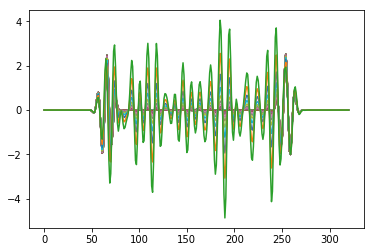

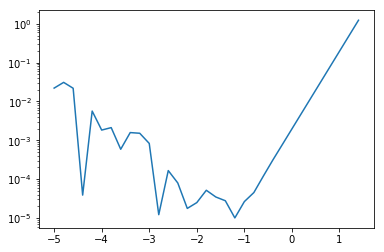

In [37]:
results = np.zeros(len(eps))
mf_a = np.zeros(len(eps))
plt.figure
for i in range(len(eps)):
    print(i)
    val = 10**eps[i]
    msr1,corr = get_misfit_from_direction(val*direction)
    msr2,corr2 = get_misfit_from_direction(-val*direction)
    mf_approx = 1./(2.*val)*(msr1-msr2)
    print(mf_approx)
    results[i] = np.abs(m_grad-mf_approx)/np.abs(m_grad)
    mf_a[i] = mf_approx
    print(results[i])
    plt.plot(corr)

plt.show()
plt.semilogy(eps,results)
plt.show()

In [38]:
# removing copied files...
os.system('rm -rf ../test/testdata/testsrc/wavefield_processed')
os.system('rm ../test/testdata/testsrc/step_0/starting_model.h5')
os.system('rm -rf ../test/testdata/testsrc/step_0/corr')
os.system('rm -rf ../test/testdata/testsrc/step_0/adjt')
os.system('rm -rf ../test/testdata/testsrc/step_0/kern')
os.system('rm -rf ../test/testdata/testsrc/step_0/grad')
os.system('rm ../test/testdata/testsrc/measr_config.json')
os.system('rm ../test/testdata/testsrc/source_config.json')
os.system('rm ../test/testdata/config.json')

0

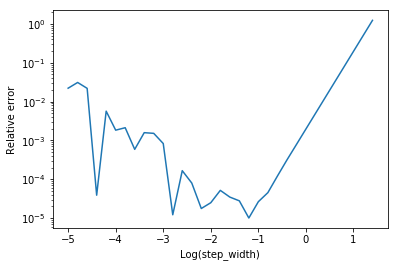

In [39]:
plt.semilogy(eps,results)
plt.xlabel('Log(step_width)')
plt.ylabel('Relative error')
plt.show()

In [19]:
print(msr2)

37751.3285963
